In [207]:
import pandas as pd
import numpy as np
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt

In [229]:
df = pd.read_csv('../../../DataSets/dataset_merged.csv')

In [230]:
df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'],format=r"%Y-%m-%d %H:%M:%S")
df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'],format=r"%Y-%m-%d %H:%M:%S")

In [231]:
df.columns

Index(['Unnamed: 0', 'trip_start_timestamp', 'unique_key', 'taxi_id',
       'trip_start_timestamp.1', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_community_area', 'dropoff_community_area', 'fare',
       'tips', 'extras', 'trip_total', 'payment_type', 'date', 'DateTime',
       'daytype', 'temperature', 'relative_humidity', 'wind_direction',
       'wind_speed', 'precipitation', 'sky_level'],
      dtype='object')

In [232]:
df.index = df['trip_start_timestamp']

In [233]:
#Drop missing values of 2017-01-01 I dont know why it was still there
df = df[~df['temperature'].isna()]
df = df[~df['daytype'].isna()]

In [234]:
df.isna().sum()

Unnamed: 0                0
trip_start_timestamp      0
unique_key                0
taxi_id                   0
trip_start_timestamp.1    0
trip_end_timestamp        0
trip_seconds              0
trip_miles                0
pickup_community_area     0
dropoff_community_area    0
fare                      0
tips                      0
extras                    0
trip_total                0
payment_type              0
date                      0
DateTime                  0
daytype                   0
temperature               0
relative_humidity         0
wind_direction            0
wind_speed                0
precipitation             0
sky_level                 0
dtype: int64

In [249]:
df.head()

,Unnamed: 0,trip_start_timestamp,unique_key,taxi_id,trip_start_timestamp.1,trip_end_timestamp,trip_seconds,trip_miles,pickup_community_area,dropoff_community_area,...,payment_type,date,DateTime,daytype,temperature,relative_humidity,wind_direction,wind_speed,precipitation,sky_level
trip_start_timestamp,,,,,,,,,,,,,,,,,,,,,
2019-01-19 13:30:00,0,2019-01-19 13:30:00,977e465c878cd5337c2215e291ecf091cf2ef4a6,84dab24222c24f99f6c543a5d02e5b47940df071fef3ed...,2019-01-19 13:30:00,2019-01-19 13:30:00,19.0,0.1,14,14,...,Cash,01/19/2019,2019-01-19 13:30:00+00:00,A,25.0,84.53,30.0,21.0,0.0,OVC
2019-01-24 07:15:00,1,2019-01-24 07:15:00,f9eb08f49f09e56188333a95bea1d9d7220a79a9,15ba3f3c77572f9fe6f7cd47e70fa31af10194449cc975...,2019-01-24 07:15:00,2019-01-24 07:30:00,328.0,1.1,14,14,...,Cash,01/24/2019,2019-01-24 07:15:00+00:00,W,10.0,87.37,240.0,6.0,0.0,FEW
2019-02-07 21:45:00,2,2019-02-07 21:45:00,6c40ff49c9e05b30bef35ba2c0c0639fe3506127,b259515344f28837cc7546ff185da59066c4aa0c2ad490...,2019-02-07 21:45:00,2019-02-07 21:45:00,213.0,0.9,14,14,...,Cash,02/07/2019,2019-02-07 21:45:00+00:00,W,18.0,67.33,250.0,22.0,0.0,OVC
2019-02-20 18:00:00,3,2019-02-20 18:00:00,4c0c28580737e54f83246154655e06344e27897c,6551ba527f916e0b8187165d7e61705fc2641c9b3afd69...,2019-02-20 18:00:00,2019-02-20 18:00:00,348.0,0.9,14,14,...,Cash,02/20/2019,2019-02-20 18:00:00+00:00,W,37.0,81.93,230.0,12.0,0.0,OVC
2019-02-13 08:30:00,4,2019-02-13 08:30:00,b01e270fa78b2b711a606dfd41bc7bb10ce2e460,98218edd8c1afe2aa636693c931d34e5bdd76df10e1b6a...,2019-02-13 08:30:00,2019-02-13 08:45:00,435.0,0.8,14,14,...,Cash,02/13/2019,2019-02-13 08:30:00+00:00,W,10.9,88.21,260.0,14.0,0.0,FEW


In [235]:
df_grouped = df.groupby([pd.Grouper(freq='H'),'pickup_community_area']).count()

In [236]:
df_grouped.head()

Unnamed: 0  trip_start_timestamp  \
trip_start_timestamp pickup_community_area                                     
2017-01-02           1                               2                     2   
                     2                               2                     2   
                     3                               4                     4   
                     4                               3                     3   
                     5                               1                     1   

                                            unique_key  taxi_id  \
trip_start_timestamp pickup_community_area                        
2017-01-02           1                               2        2   
                     2                               2        2   
                     3                               4        4   
                     4                               3        3   
                     5                               1        1   

                                            trip_start_timestamp.1  \
trip_start_timestamp pickup_community_area                           
2017-01-02           1                                           2   
                     2                                           2   
                     3                                           4   
                     4                                           3   
                     5                                           1   

                                            trip_end_timestamp  trip_seconds  \
trip_start_timestamp pickup_community_area                                     
2017-01-02           1                                       2             2   
                     2                                       2             2   
                     3                                       4             4   
                     4                                       3             3   
                     5                                       1             1   

                                            trip_miles  \
trip_start_timestamp pickup_community_area               
2017-01-02           1                               2   
                     2                               2   
                     3                               4   
                     4                               3   
                     5                               1   

                                            dropoff_community_area  fare  ...  \
trip_start_timestamp pickup_community_area                                ...   
2017-01-02           1                                           2     2  ...   
                     2                                           2     2  ...   
                     3                                           4     4  ...   
                     4                                           3     3  ...   
                     5                                           1     1  ...   

                                            payment_type  date  DateTime  \
trip_start_timestamp pickup_community_area                                 
2017-01-02           1                                 2     2         2   
                     2                                 2     2         2   
                     3                                 4     4         4   
                     4                                 3     3         3   
                     5                                 1     1         1   

                                            daytype  temperature  \
trip_start_timestamp pickup_community_area                         
2017-01-02           1                            2            2   
                     2                            2            2   
                     3                            4            4   
                     4                            3            3   
                     5                       

In [237]:
series_y = df_grouped['Unnamed: 0']
final_df = pd.DataFrame(index = df_grouped.index,columns = ['Trips'])
final_df['Trips'] = series_y

In [238]:
final_df

Trips
trip_start_timestamp pickup_community_area       
2017-01-02           1                          2
                     2                          2
                     3                          4
                     4                          3
                     5                          1
...                                           ...
2019-12-01           15                         2
                     24                         2
                     28                         2
                     32                         1
                     76                        16

[659255 rows x 1 columns]

We realize that there are a lot of hours with missing community areas:


In [239]:
tmp = df.groupby(pd.Grouper(freq='H'))
tmp = tmp.agg({"pickup_community_area": "nunique"})
tmp = tmp.reset_index()

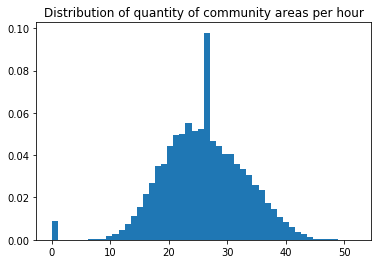

In [240]:
plt.hist(tmp['pickup_community_area'], density = True, bins= 50)
plt.title('Distribution of quantity of community areas per hour')
plt.show()

So we will create a dataframe with all hours and all community areas:

In [241]:
hours = df_grouped.index.get_level_values(0).unique()

In [242]:
index_hours = []
index_ca = []
for h in hours:
    index_hours += [h] * 77
    index_ca += range(1,78)

In [243]:
final_df_preprocessed = pd.DataFrame(index=[index_hours,index_ca])

In [244]:
final_df_preprocessed.index.names = ['trip_start_timestamp','pickup_community_area']

In [245]:
final_df_preprocessed['Trips'] = 0

In [246]:
final_df_preprocessed = final_df_preprocessed.add(final_df,fill_value=0)
final_df_preprocessed['Trips'] = final_df_preprocessed['Trips'].astype('int8')

In [247]:
del(final_df)
final_df = final_df_preprocessed

In [248]:
final_df

Trips
trip_start_timestamp pickup_community_area       
2017-01-02           1                          2
                     2                          2
                     3                          4
                     4                          3
                     5                          1
...                                           ...
2019-12-01           73                         0
                     74                         0
                     75                         0
                     76                        16
                     77                         0

[1946021 rows x 1 columns]

In [253]:
weather_info = df.groupby([pd.Grouper(freq='H'),'pickup_community_area']).mean()[['temperature','relative_humidity','wind_direction','wind_speed','precipitation']]

In [265]:
hours = final_df.index.get_level_values(0).unique()

In [345]:
temp = []
humidity = []
wind_dir = []
wind_speed = []
precipitation = []
skyLevel = []
dayType = []

for i in range(len(hours)):
    sample_group = weather_info.loc[hours[i]].iloc[0]
    
    try:
        sample = df.loc[hours[i]]
        if isinstance(sample,pd.DataFrame):
            sample = sample.iloc[0]
    except:
        mask = (df['trip_start_timestamp'] > hours[i]) & (df['trip_start_timestamp'] < hours[i+1])
        sample = df[mask].iloc[0]
    temp += [sample_group['temperature']] * 77
    humidity += [sample_group['relative_humidity']] * 77
    wind_dir += [sample_group['wind_direction']] * 77
    wind_speed += [sample_group['wind_speed']] * 77
    precipitation += [sample_group['precipitation']] * 77
    try:
        skyLevel += [sample['sky_level']] * 77
    except:
        print(i)
        print(sample)
    dayType += [sample['daytype']] * 77

In [ ]:
final_df['temperature'] = temp
final_df['relative_humidity'] = humidity
final_df['wind_direction'] = wind_dir
final_df['wind_speed'] = wind_speed
final_df['precipitation'] = precipitation
final_df['daytype'] = dayType
final_df['sky_level'] = skyLevel
del(temp)
del(humidity)
del(wind_dir)
del(wind_speed)
del(precipitation)
del(skyLevel)
del(precipitation)

In [347]:
final_df

Trips  temperature  \
trip_start_timestamp pickup_community_area                       
2017-01-02           1                          2         28.9   
                     2                          2         28.9   
                     3                          4         28.9   
                     4                          3         28.9   
                     5                          1         28.9   
...                                           ...          ...   
2019-12-01           73                         0         39.9   
                     74                         0         39.9   
                     75                         0         39.9   
                     76                        16         39.9   
                     77                         0         39.9   

                                            relative_humidity  wind_direction  \
trip_start_timestamp pickup_community_area                                      
2017-01-02           1                                  82.00            50.0   
                     2                                  82.00            50.0   
                     3                                  82.00            50.0   
                     4                                  82.00            50.0   
                     5                                  82.00            50.0   
...                                                       ...             ...   
2019-12-01           73                                 96.55           140.0   
                     74                                 96.55           140.0   
                     75                                 96.55           140.0   
                     76                                 96.55           140.0   
                     77                                 96.55           140.0   

                                            wind_speed  precipitation daytype  \
trip_start_timestamp pickup_community_area                                      
2017-01-02           1                             5.0           0.00       U   
                     2                             5.0           0.00       U   
                     3                             5.0           0.00       U   
                     4                             5.0           0.00       U   
                     5                             5.0           0.00       U   
...                                                ...            ...     ...   
2019-12-01           73                            7.0           1.78       U   
                     74                            7.0           1.78       U   
                     75                            7.0           1.78       U   
                     76                            7.0           1.78       U   
                     77                            7.0           1.78       U   

                                           sky_level  
trip_start_timestamp pickup_community_area            
2017-01-02           1                           FEW  
                     2                           FEW  
                     3                           FEW  
                     4                           FEW  
                     5                           FEW  
...                                              ...  
2019-12-01           73                          OVC  
                     74                          OVC  
                     75                          OVC  
                     76                          OVC  
                     77                          OVC  

[1946021 rows x 8 columns]

In [531]:
final_df.loc[:,'trip_start_timestamp'] = final_df.index.get_level_values(0)

In [532]:
final_df.loc[:,'pickup_community_area'] = final_df.index.get_level_values(1)

### Feature Engineering

**Hour, Day , Quarter, Month**

In [538]:
final_df.loc[:,'Day Name'] = final_df['trip_start_timestamp'].dt.day_name()

In [543]:
final_df.loc[:,'Month'] = final_df['trip_start_timestamp'].dt.month

In [547]:
final_df.loc[:,'Hour'] = final_df['trip_start_timestamp'].dt.hour

In [549]:
final_df.loc[:,'Quarter'] = final_df['trip_start_timestamp'].dt.quarter

**Fare and Tips**

In [350]:
# Fare from the last month per community area
# Group by by month and community area and sum
income_grouped = df.groupby([pd.Grouper(freq='M'),'pickup_community_area'])[['fare','tips']].sum()

In [355]:
income_grouped

DatetimeIndex(['2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31', '2019-06-30', '2019-07-31', '2019-08-31',
               '2019-09-30', '2019-10-31', '2019-11-30', '2019-12-31'],
              dtype='datetime64[ns]', name='trip_start_timestamp', freq='M')

In [393]:
income_grouped

fare     tips
trip_start_timestamp pickup_community_area                   
2017-01-31           1                      32055.00  1485.59
                     2                      36413.10  1224.73
                     3                      65230.40  3568.52
                     4                      46732.45  2536.66
                     5                      33088.75  1832.27
...                                              ...      ...
2019-12-31           15                        24.00     2.80
                     24                        27.50     3.00
                     28                        31.00     0.00
                     32                         8.50     2.00
                     76                       628.25    55.63

[2705 rows x 2 columns]

In [394]:
final_df['Fare Last Month'] = 0
final_df['Tips Last Month'] = 0

In [414]:
for month, ca in income_grouped.index:
    
    fare = income_grouped.loc[(month,ca),'fare']
    tips = income_grouped.loc[(month,ca),'tips']
    maskMonth = (final_df['trip_start_timestamp'] <= month) & (final_df['trip_start_timestamp'] >= (month - pd.offsets.MonthBegin(1)) )
    
    final_df.loc[(maskMonth,ca),'Fare Last Month'] = fare
    final_df.loc[(maskMonth,ca),'Tips Last Month'] = tips

In [448]:
final_df[:80]

Trips  temperature  \
trip_start_timestamp pickup_community_area                       
2017-01-02 00:00:00  1                          2         28.9   
                     2                          2         28.9   
                     3                          4         28.9   
                     4                          3         28.9   
                     5                          1         28.9   
...                                           ...          ...   
                     76                        19         28.9   
                     77                         5         28.9   
2017-01-02 01:00:00  1                          6         30.0   
                     2                          2         30.0   
                     3                          6         30.0   

                                            relative_humidity  wind_direction  \
trip_start_timestamp pickup_community_area                                      
2017-01-02 00:00:00  1                                   82.0            50.0   
                     2                                   82.0            50.0   
                     3                                   82.0            50.0   
                     4                                   82.0            50.0   
                     5                                   82.0            50.0   
...                                                       ...             ...   
                     76                                  82.0            50.0   
                     77                                  82.0            50.0   
2017-01-02 01:00:00  1                                   78.4            50.0   
                     2                                   78.4            50.0   
                     3                                   78.4            50.0   

                                            wind_speed  precipitation daytype  \
trip_start_timestamp pickup_community_area                                      
2017-01-02 00:00:00  1                             5.0            0.0       U   
                     2                             5.0            0.0       U   
                     3                             5.0            0.0       U   
                     4                             5.0            0.0       U   
                     5                             5.0            0.0       U   
...                                                ...            ...     ...   
                     76                            5.0            0.0       U   
                     77                            5.0            0.0       U   
2017-01-02 01:00:00  1                             4.0            0.0       U   
                     2                             4.0            0.0       U   
                     3                             4.0            0.0       U   

                                           sky_level trip_start_timestamp  \
trip_start_timestamp pickup_community_area                                  
2017-01-02 00:00:00  1                           FEW  2017-01-02 00:00:00   
                     2                           FEW  2017-01-02 00:00:00   
                     3                           FEW  2017-01-02 00:00:00   
                     4                           FEW  2017-01-02 00:00:00   
                     5                           FEW  2017-01-02 00:00:00   
...                                              ...                  ...   
                     76                          FEW  2017-01-02 00:00:00   
                     77                          FEW  2017-01-02 00:00:00   
2017-01-02 01:00:00  1                           FEW  2017-01-02 01:00:00   
                     2                           FEW  2017-01-02 01:00:00   
                     3                           FEW  2017-01-02 01:00:00   

                                            Fare Last Month  Tips Last Mont

**Demand of last hour, last week and two weeks ago (same hour)**

In [449]:
final_df['Trips Last Hour'] = np.NAN
final_df['Trips Last Week (Same Hour)'] = np.NAN
final_df['Trips 2 Weeks Ago (Same Hour)'] = np.NAN

In [457]:
trips = final_df['Trips'].values
trips_lastHour = np.insert(trips,0,[0] * 77)
trips_lastHour = trips_lastHour[:-77]

In [458]:
final_df['Trips Last Hour'] = trips_lastHour

In [473]:
# Check if it is correct
print(final_df.loc[("2018-04-07 10:00:00",76),'Trips Last Hour'][0] == final_df.loc[("2018-04-07 09:00:00",76),'Trips'][0])
print(final_df.loc[("2017-09-18 17:00:00",76),'Trips Last Hour'][0] == final_df.loc[("2017-09-18 16:00:00",76),'Trips'][0])

True
True


In [482]:
offset = (7 * 24) * 77 # 7 days * 24 hours * 77 community areas
trips_lastWeekHour = np.insert(trips,0,[0] * offset)
trips_lastWeekHour = trips_lastWeekHour[:-offset]

In [483]:
final_df['Trips Last Week (Same Hour)'] = trips_lastWeekHour

In [485]:
# Check if it is correct
print(final_df.loc[("2018-04-07 10:00:00",76),'Trips Last Week (Same Hour)'][0] == final_df.loc[("2018-03-31 10:00:00",76),'Trips'][0])
print(final_df.loc[("2017-09-18 17:00:00",76),'Trips Last Week (Same Hour)'][0] == final_df.loc[("2017-09-11 17:00:00",76),'Trips'][0])

True
True


In [486]:
offset = (14 * 24) * 77 # 14 days * 24 hours * 77 community areas
trips_last2WeeksHour = np.insert(trips,0,[0] * offset)
trips_last2WeeksHour = trips_last2WeeksHour[:-offset]

In [487]:
final_df['Trips 2 Weeks Ago (Same Hour)'] = trips_last2WeeksHour

In [488]:
# Check if it is correct
print(final_df.loc[("2018-04-07 10:00:00",76),'Trips 2 Weeks Ago (Same Hour)'][0] == final_df.loc[("2018-03-24 10:00:00",76),'Trips'][0])
print(final_df.loc[("2017-09-18 17:00:00",76),'Trips 2 Weeks Ago (Same Hour)'][0] == final_df.loc[("2017-09-04 17:00:00",76),'Trips'][0])

True
True


As we are using information from the last two week, we delete the samples related to the first two weeks of the dataset

In [496]:
final_df = final_df.iloc[offset:]

In [554]:
final_df

Trips  temperature  \
trip_start_timestamp pickup_community_area                       
2017-01-16           1                          1         30.0   
                     2                          0         30.0   
                     3                          4         30.0   
                     4                          3         30.0   
                     5                          2         30.0   
...                                           ...          ...   
2019-12-01           73                         0         39.9   
                     74                         0         39.9   
                     75                         0         39.9   
                     76                        16         39.9   
                     77                         0         39.9   

                                            relative_humidity  wind_direction  \
trip_start_timestamp pickup_community_area                                      
2017-01-16           1                                  78.40           130.0   
                     2                                  78.40           130.0   
                     3                                  78.40           130.0   
                     4                                  78.40           130.0   
                     5                                  78.40           130.0   
...                                                       ...             ...   
2019-12-01           73                                 96.55           140.0   
                     74                                 96.55           140.0   
                     75                                 96.55           140.0   
                     76                                 96.55           140.0   
                     77                                 96.55           140.0   

                                            wind_speed  precipitation daytype  \
trip_start_timestamp pickup_community_area                                      
2017-01-16           1                             4.0           0.00       U   
                     2                             4.0           0.00       U   
                     3                             4.0           0.00       U   
                     4                             4.0           0.00       U   
                     5                             4.0           0.00       U   
...                                                ...            ...     ...   
2019-12-01           73                            7.0           1.78       U   
                     74                            7.0           1.78       U   
                     75                            7.0           1.78       U   
                     76                            7.0           1.78       U   
                     77                            7.0           1.78       U   

                                           sky_level trip_start_timestamp  \
trip_start_timestamp pickup_community_area                                  
2017-01-16           1                           OVC           2017-01-16   
                     2                           OVC           2017-01-16   
                     3                           OVC           2017-01-16   
                     4                           OVC           2017-01-16   
                     5                           OVC           2017-01-16   
...                                              ...                  ...   
2019-12-01           73                          OVC           2019-12-01   
                     74                          OVC           2019-12-01   
                     75                          OVC           2019-12-01   
                     76                          OVC           2019-12-01   
                     77                          OVC           2019-12-01   

                                            Fare Last Month  Tips Last Mont

In [ ]:
final_df['trip_start_timestamp'] = final_df['trip_start_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M:%S'))

In [556]:
final_df.to_csv('../../../DataSets/dataset_final.csv')

### Multicollinearity

In [551]:
corr = final_df.corr()
corr[corr > 0.5]

,Trips,temperature,relative_humidity,wind_direction,wind_speed,precipitation,Fare Last Month,Tips Last Month,pickup_community_area,Trips Last Hour,Trips Last Week (Same Hour),Trips 2 Weeks Ago (Same Hour),Month,Hour,Quarter
Trips,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.584019,0.562262,0.544587,NaN,NaN,NaN
temperature,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relative_humidity,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wind_direction,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wind_speed,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
precipitation,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare Last Month,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.983469,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Tips Last Month,NaN,NaN,NaN,NaN,NaN,NaN,0.983469,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_community_area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
Trips Last Hour,0.584019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN


There is a high correlation between:
- Fare Last Month~Tips Last Month
- Month~Quarter

In [552]:
final_df[['Trips','Fare Last Month','Tips Last Month','Month','Quarter']].corr()

,Trips,Fare Last Month,Tips Last Month,Month,Quarter
Trips,1.000000,0.367100,0.348193,-0.001559,-0.001658
Fare Last Month,0.367100,1.000000,0.983469,0.000400,-0.000764
Tips Last Month,0.348193,0.983469,1.000000,0.002680,0.001525
Month,-0.001559,0.000400,0.002680,1.000000,0.970224
Quarter,-0.001658,-0.000764,0.001525,0.970224,1.000000
